# Project 5
**Author:** Tommy Phung <br>
**Target:** Video Game Developers

## Business Understanding 
Video games have been a form of entertainment for all ages around the world. There has been **an increase in game production** with all the access to tools online as well as the demand for these games especially for the last couple of years of quarantine. Every year, **Steam**, one of the largest online video game platforms, has **300 games** on average published a day and this has only been increasing in the past decade.  
With so many games getting published, there is **a risk that the game won't be made profitable**. 
Depending on the **company size**, the number of sales changes can be a sign of a profitable game. <br>

For example, Triple-A games are expected to have a sale of **10 million units** whereas Indie games, which are smaller game companies, would expect **100,000 units** to be successful. 
There is also a bigger budget range when comparing Triple-A companies and Indie companies. 
To make a game that many would be interested in buying, **certain genres are more desirable than others** for the average player. By modeling the genres of the games, we can **isolate the genres to the best** to have when making a game that would **reach the benchmark** mentioned above. 

This information would be useful to have for **Indie developers** that would sell their games on Steam but can apply to other platforms. If a **new developer** is attempting to create a game, they should use the information to determine the best type of game that the audience would want to buy. **Triple-A** companies using the model should look at the worst genres and avoid those since they are already established and could improve their current library of games instead. 

## Data Understanding 
The first dataset came from [Backloggd](https://www.backloggd.com/) and [Kaggle](https://www.kaggle.com/). <br>
Backloggd is a **community-based** listing website that takes lists of games and combined them with various features such as **ratings, played and wishlist**. The main feature we looked at is **genres** with some insight gained from the Ratings feature.

The second dataset contians the **sales of games** from various regions. I looked at **Global Sales** which is just the sum of all the columns in the dataset. 

Since I am using both dataset, they **need to match** with one another to anaysis them fairly. This was the brekadown on the number of games and the final resulting dataframe. 

|  | Backloggd | Ranked | **Final** |
|---|:---:|:---:|:---:|
| **# of Games** | 60,000 | 16,598 | **4,466** |
| **Desired Feature** | Genres | Global Sales | **N/A** |
| **# of Columns** | 12 | 10 | **6** |

## Data Preperations
To prepare the dataset, I looked for duplicates. There was **no missing values** that would impact the modeling. <br>
Three columns from the two datasets that matter were the **Title, Genres, and Ratings**. <br>
Genres needed to be formatted so that the literal string can be converted to an actual list of genres to manipulate. Since the ranked dataset separates games based on platforms, I grouped the sales and summed the values to a single unique title. 

The last step was to create two different columns to **indicate profitability**. Two metrics to consider was that triple-A title has higher expected sales to be profitable while Indie games have a lower threshold. I determine the threshold being **1 million or 1 in global sales for Triple-A** and **100,000 or .1 for Indie Games.**

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Modeling Libraries used 
from sklearn.tree import DecisionTreeClassifier    # Baseline classifier
from sklearn.ensemble import RandomForestClassifier   # Ensemble 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

### Import Custom Functions
Custom functions were created for clearer graph and clean up clutter in notebook.

In [2]:
# Uncomment code to download functions created from the project if using Google Colab
# ! mkdir functions 
# ! wget https://raw.githubusercontent.com/Tommyphung1/Project_5/master/functions/data_visuals.py -P functions
# ! wget https://raw.githubusercontent.com/Tommyphung1/Project_5/master/functions/data_cleaning.py -P functions

### Custom Functions

In [3]:
### Custom made functions for cleaning data
from functions import data_cleaning as dc 
from functions import data_visuals as dv

In [4]:
df = pd.read_csv('datasets/backloggd_games.csv', index_col= 0)    ### Main dataset with the genres.
ranked_df = pd.read_csv('datasets/vgsales.csv')                   ### Dataset to grab global sales from. 
comb_df = df[df.Title.isin(ranked_df.Name.unique())]              ### Only take the titles that matches
comb_df.reset_index(drop= True, inplace = True)                   ### Resest the index for nice visuals

#### Extract Useful Columns

In [5]:
comb_df = comb_df[['Title', 'Genres', 'Rating']]           ### Only Take the useable features
comb_df.drop_duplicates(subset= 'Title', inplace= True)    ### Drop any duplicates
comb_df.Genres = df.Genres.apply(dc.convert_to_list)       ### Convert to list like

#### Combine Second Dataset Column

In [6]:
matched_df = ranked_df[ranked_df.Name.isin(comb_df.Title.unique())][['Name', 'Global_Sales', 'Platform']]    ### Only Game title that are in both datasets.
final_df = comb_df.sort_values('Title')                                                                      ### Sort the Titles
final_df['Global_Sales'] = matched_df.groupby('Name').sum().sort_values('Name').Global_Sales.values          ### Group the titles and sum the similar name entry in the dataset.
final_df.reset_index(drop= True, inplace= True)                                                              ### Reset the index 

#### Add Two Custom Columns

In [7]:
### Add a new column with all 0. 
final_df['Over_1'] = 0
final_df['Over_.1'] = 0
final_df.loc[final_df['Title'].isin(ranked_df[ranked_df.Global_Sales >= 1].Name.values), 'Over_1'] = 1      ### Set 1 if over 1
final_df.loc[final_df['Title'].isin(ranked_df[ranked_df.Global_Sales >= .1].Name.values), 'Over_.1'] = 1    ### Set 1 if over .1

## Data Distribution
There are **24 genres** with the most common being **Adventure, Indie, RPG, Shooter, and Puzzle**. <br>
When looking at the Ratings for the games, there is a **normal distribution** which indicates that there is an even number of bad and good games in the list. 


### Class Distributions
When the benchmark for profit is over 1 million units of sales for a video game. <br>
**74.2%** was marked as not profitable <br>
**25.8%** was marked as profitable

When considering Indie games and their benchmark for profit, <br>
**20.9%** was marked as not profitable <br>
**79.1%** was marked as profitable

#### Class Inbalance Graph

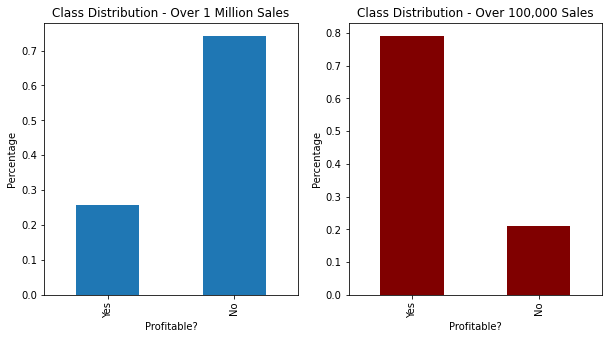

In [8]:
### Graphing the distribution of the classes
### Two of the graphs are from there respective threshholds


fig, ax = plt.subplots(ncols= 2, figsize = (10,5))

final_df['Over_1'].value_counts(normalize= True,ascending= True).plot(kind = 'bar', ax = ax[0])
ax[0].set_title('Class Distribution - Over 1 Million Sales');
ax[0].set_xlabel('Profitable?')
ax[0].set_xticklabels(['Yes', 'No'])
ax[0].set_ylabel('Percentage');

final_df['Over_.1'].value_counts(normalize= True).plot(kind = 'bar', ax = ax[1], color = 'maroon')
ax[1].set_title('Class Distribution - Over 100,000 Sales');
ax[1].set_xlabel('Profitable?')
ax[1].set_xticklabels(['Yes', 'No']);
ax[1].set_ylabel('Percentage');

Only **25.8%** of the games were able to make a sale of over 1 million. <br>
While the **74.2%** was unable to reach that benchmark. <br>
The benchmark differs from the size of the company. 

When considering most indie games consider sales over **100,000** sales to be successful, more games reached that benchmark. <br>
**79.1%** of games were considered profitable while only **20.9%** weren't able to. This makes sense since most games have to start as an indie developer before being a successful Triple-A title. 

### Rating Distribution Graph

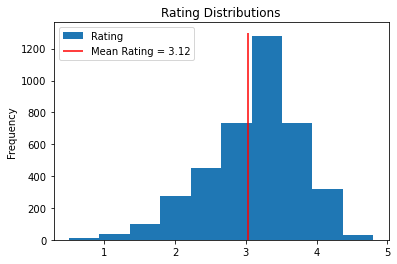

In [9]:
### Rating Distrbution 
final_df[final_df.Rating >= 0].Rating.plot(kind = 'hist', title = 'Rating Distributions', xlabel = 'Rating', sharex = False);
plt.vlines(df.Rating.mean(), 0, 1300, colors= 'red', label= 'Mean Rating = {}'.format(round(final_df.Rating.mean(), 2)));
plt.legend();

Normal distrbution of games would mean that all types of games were included leaving for a balanced dataset. <br>
If all or most of the **games perform well**, that would **indirectly lead** to **better sales** in most cases. 
Instead, since this website was built by the fanbase, there should be a balance of popular games and more obsure games.

### Genres Distribution Graph

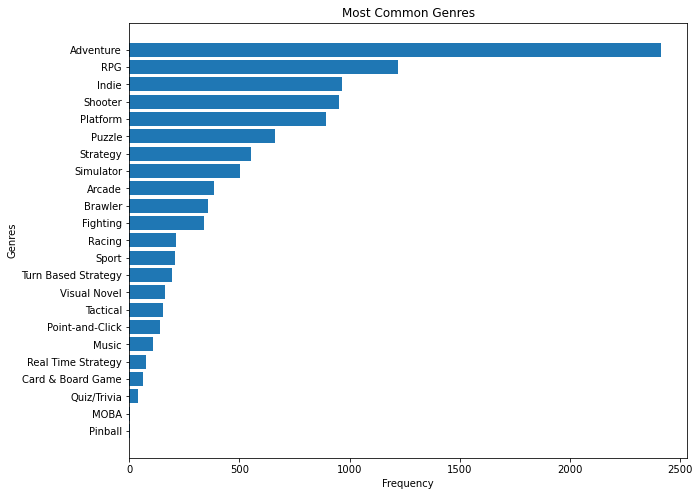

In [10]:
sort_genres = dc.count_values(final_df.Genres.values)    ### Value count the genres from the dataset

### Plot the genres distribution
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(list(sort_genres.keys()), list(sort_genres.values()));
ax.set_title('Most Common Genres');
ax.set_ylabel('Genres');
ax.set_xlabel('Frequency');

Unsurprisingly, **adventure** was the most common genre in the dataset having roughly **2500** with this tag, followed by **RGP, Indie, Shooter, and Platform**. <br>
Due to the number of games with these genres, we can expect that most of the profitable games would have **similar genres**.

## Baseline Models
The baseline model will be a Decision Tree with default parameters to have something to compare the different models and which performs the best. 
Two baseline models are made for the two conditions, the 100,000 unit threshold and the 1 million unit threshold. A random state of 10 was used on all the models to keep consistency. 

In [11]:
### Create dataframe that have the features of the games, title, and target features
genre_df = pd.concat([final_df.Title, pd.get_dummies(final_df['Genres'].explode(),drop_first= True).groupby(level=0).sum(), final_df[['Over_1', 'Over_.1']]], axis= 1)

In [12]:
X = genre_df[genre_df.columns[1:-2]]    ### Include only the feature columns
y =  genre_df.Over_1   ### Target column over 1 selected

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 10)    ### Create the training and testing set with the values
y_train_2 = genre_df.loc[X_train.index]['Over_.1']   ### Using the same index, declare a new y_train
y_test_2 = genre_df.loc[X_test.index]['Over_.1']     ### Using the same index, declare a new y_test

In [13]:
### Over 1 Million
baseline = DecisionTreeClassifier(random_state=10)   ### Declare the classifier 
baseline.fit(X_train, y_train)   ### Train the classifier

### Over 100,000
baseline_2 = DecisionTreeClassifier(random_state=10)   ### Declare the classifier 
baseline_2.fit(X_train, y_train_2)    ### Train the classifier

DecisionTreeClassifier(random_state=10)

### Baseline Results 

In [14]:
print('Over 1 M Model')
print('--------------')
print('F1-Score: {}%'.format(round(f1_score(y_test,baseline.predict(X_test))* 100,2)))
print('Accuracy: {}%'.format(round(accuracy_score(y_test,baseline.predict(X_test))* 100,2)))
print('--------------')

print('Over 100,000 Model')
print('--------------')
print('F1-Score: {}%'.format(round(f1_score(y_test_2,baseline_2.predict(X_test))* 100,2)))
print('Accuracy: {}%'.format(round(accuracy_score(y_test_2,baseline_2.predict(X_test))* 100,2)))
print('--------------')

Over 1 M Model
--------------
F1-Score: 16.35%
Accuracy: 72.52%
--------------
Over 100,000 Model
--------------
F1-Score: 86.76%
Accuracy: 77.08%
--------------


### Baseline Model Anaysis
From the baseline models, there was a **72.52%** accuracy when determine whether a game would sell over 1 million units. <br>
There was a slight increase in the accuracy when determinng if a game would sell over 100,000 with **77.08%** accuracy.
It would be reasonable to assume that the model is more accurate when looking for games that sold more than 100,000 units since more games.
When looking at the **F1-Score**, we can see that the model was able to predict the succuess of games with over 100,000 sales much **better** than the model predicting if the game sold more than 1 million units. From **16.35% to 86.76%**, using genres to predict games making more than 100,000 game sales is **much more accurate**. 

## Feature Importance Graphs
The model provides feature importances for each feature giving a percentage to determine which was the **most important** when deciding whether the game was profitable.
However, it is important to see the distribution of the genres alone to see if the data would favor one genre or another. Assuming that more games with a given genre would be picked out more often than a rare genre. 

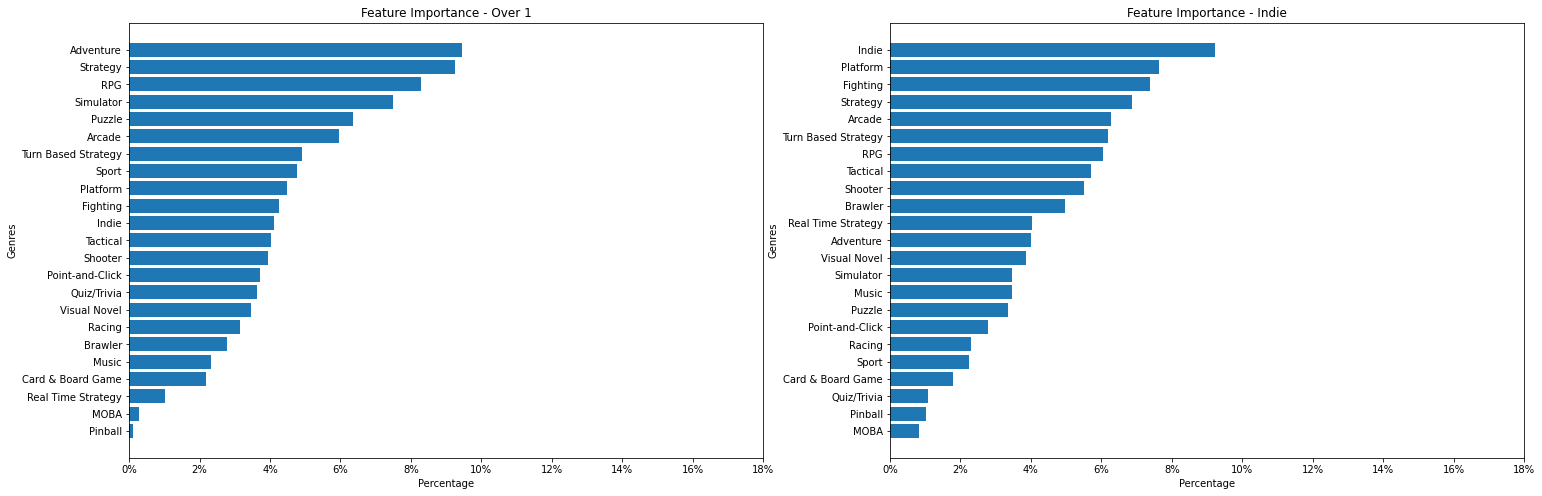

In [15]:
feature_list = dc.convert_feature(baseline)   ### Take the feature importance and make them to lists
feature_list_2 = dc.convert_feature(baseline_2)    ### Take the feature importance and make them to lists

dv.visual_baseline(feature_list, feature_list_2)   ### Visualize the feature importance from two lists

### Top Five Features Importance

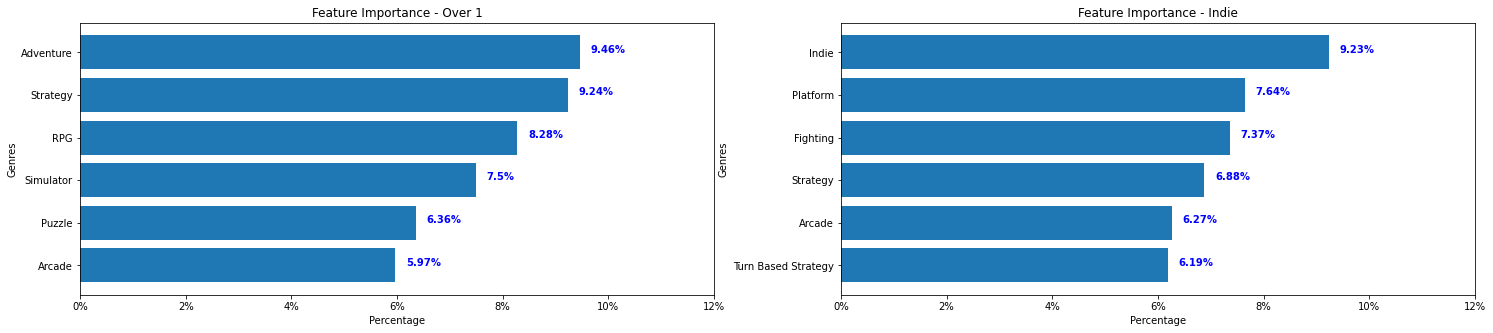

In [16]:
dv.visual_top_5(feature_list, feature_list_2)    ### Visual the top 5 genres 

Interestingly, the difference between making a games that would make 1,000,000 units is **completely different** than that of of 100,000. The only similar genre that the top 5 genres was **strategy** with **adventure and indie games** being the most importance for 1 million and 100,000 respectively. 

Looking back with most common genres, **most of those genres** appear to be in **one of the two feature importance list** with shooter being in neigher. 
This directly support the fact that even though many gaves have the title, **they are not directly correctate to a good selling games**. In other words, **some genres would work better** for **indie** games than others. 

## Random Forest Model - Default Parameter

In [17]:
random = RandomForestClassifier(random_state=10)  
random.fit(X_train, y_train) 

random_2 = RandomForestClassifier(random_state=10)  
random_2.fit(X_train, y_train_2) 

RandomForestClassifier(random_state=10)

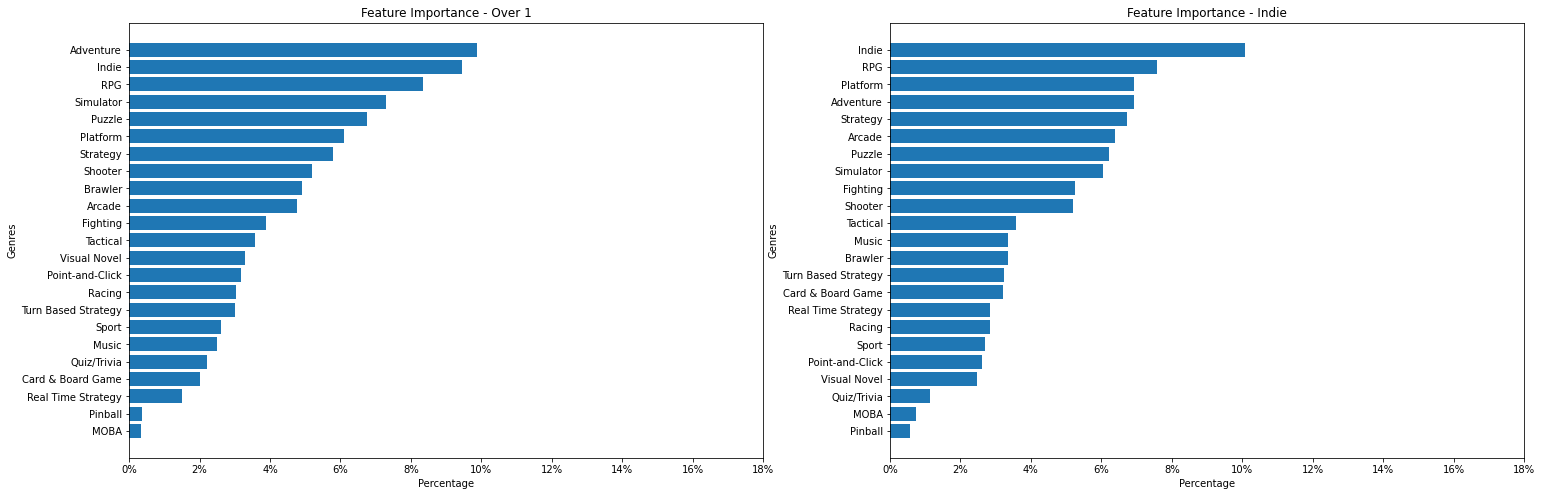

In [18]:
random_list = dc.convert_feature(random)
random_list_2 = dc.convert_feature(random_2)

dv.visual_baseline(random_list, random_list_2)

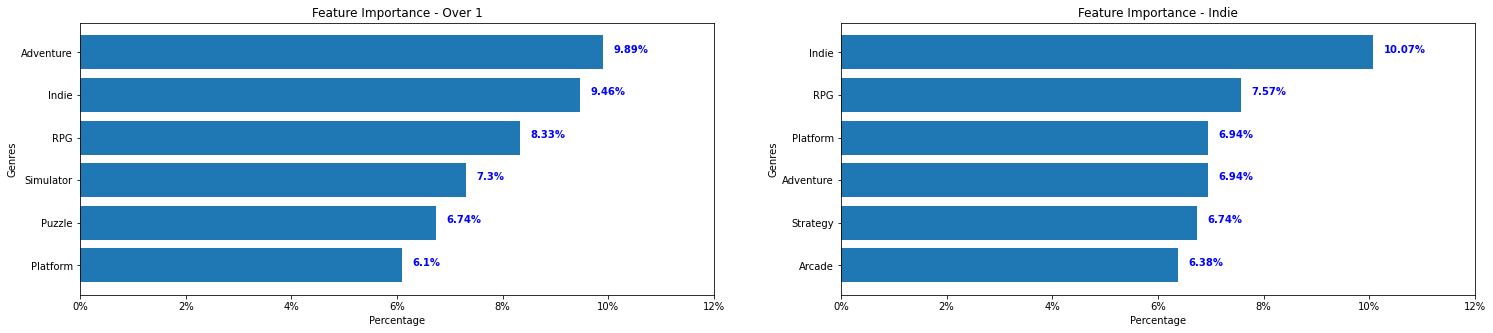

In [19]:
dv.visual_top_5(random_list, random_list_2)

## Random Forest Models - GridSearch

In [20]:
# Original Parameter Grid 
param_grid = {
                'n_estimators' : [10, 20, 50, 75, 100],
                'criterion': ['entropy', 'gini'],
                'max_depth' : [None, 10, 15, 20, 25, 30],
                'min_samples_split' : [.1, .3,.5, .7, .9, 2, 4, 6, 10],
                'min_samples_leaf' : [.1, .3,.5, .7, .9, 2, 4, 6, 10],
                'max_features' : [None, 'sqrt', 10, 15, 20],
                'random_state': [10]
             }

param_grid_2 = {
                'n_estimators' : [10, 20, 50, 75, 100],
                'criterion': ['entropy', 'gini'],
                'max_depth' : [None, 10, 15, 20, 25, 30],
                'min_samples_split' : [.1, .3,.5, .7, .9, 2, 4, 6, 10],
                'min_samples_leaf' : [.1, .3,.5, .7, .9, 1 ,2, 4, 6, 10],
                'max_features' : [None, 'sqrt', 10, 15, 20],
                'random_state': [10]
             }

In [21]:
### Over 1 Million 
forest_clf_base = RandomForestClassifier(criterion = 'entropy',max_depth = 20, max_features = 20, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 75, random_state = 10)
forest_clf_base.fit(X_train, y_train)

### Over 100,000 
forest_clf_base_2 = RandomForestClassifier(criterion = 'entropy',max_depth = 15, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 100, random_state = 10)
forest_clf_base_2.fit(X_train, y_train_2)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       random_state=10)

### Random Forest Results

In [22]:
print('Over 1 M Model')
print('--------------')
print('F1-Score: {}%'.format(round(f1_score(y_test, forest_clf_base.predict(X_test)) * 100,2)))
print('Accuracy: {}%'.format(round(accuracy_score(y_test,forest_clf_base.predict(X_test)),4) * 100))
print('--------------')

print('Over 100,000 Model')
print('--------------')
print('F1-Score: {}%'.format(round(f1_score(y_test_2, forest_clf_base_2.predict(X_test)) * 100,2)))
print('Accuracy: {}%'.format(round(accuracy_score(y_test_2,forest_clf_base_2.predict(X_test)),4) * 100))
print('--------------')

Over 1 M Model
--------------
F1-Score: 14.9%
Accuracy: 73.41%
--------------
Over 100,000 Model
--------------
F1-Score: 87.94%
Accuracy: 78.51%
--------------


In [23]:
print('Decision Tree - Baseline')
print('___________________')
print('Over 1 Million')
print('F1-Score: {}%'.format(round(f1_score(y_test, baseline.predict(X_test)), 4)* 100))          ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test, baseline.predict(X_test)), 4)* 100))    ### Over 1 Default Random Over 100,000
print('-------------------')
print('Over 100,000')
print('F1-Score: {}%'.format(round(f1_score(y_test_2, baseline_2.predict(X_test)), 2)* 100))        ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test_2, baseline_2.predict(X_test)), 4)* 100))    ### Over 1 Default Random Over 100,000

print('___________________')
print('Random Forest')
print('___________________')

print('Over 1 Million')
print('F1-Score: {}%'.format(round(f1_score(y_test, random.predict(X_test)), 4)* 100))          ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test, random.predict(X_test)), 4)* 100))
print('-------------------')
print('Over 100,000')
print('F1-Score: {}%'.format(round(f1_score(y_test_2, random_2.predict(X_test))* 100, 2)))        ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test_2, random_2.predict(X_test)) * 100, 2)))

print('___________________')
print('Random Forest GridSearch')
print('___________________')

print('Over 1 Million')
print('F1-Score: {}%'.format(round(f1_score(y_test, forest_clf_base.predict(X_test))* 100), 4))          ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test, forest_clf_base.predict(X_test)) * 100, 2)))
print('-------------------')
print('Over 100,000')
print('F1-Score: {}%'.format(round(f1_score(y_test_2, forest_clf_base_2.predict(X_test))* 100), 4))        ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test_2, forest_clf_base_2.predict(X_test)) * 100, 2)))
print('___________________')

Decision Tree - Baseline
___________________
Over 1 Million
F1-Score: 16.35%
Accuracy: 72.52%
-------------------
Over 100,000
F1-Score: 87.0%
Accuracy: 77.08%
___________________
Random Forest
___________________
Over 1 Million
F1-Score: 19.79%
Accuracy: 73.14%
-------------------
Over 100,000
F1-Score: 87.39%
Accuracy: 77.89%
___________________
Random Forest GridSearch
___________________
Over 1 Million
F1-Score: 15%
Accuracy: 73.41%
-------------------
Over 100,000
F1-Score: 88%
Accuracy: 78.51%
___________________


### Threshold 1 Million Results
|  | Over 1 Million |  |
|---|:---:|---|
| Model | F1-Score | Accuracy |
| Decision Tree | 16.35% | 72.52% |
| Random Forest | **19.79%** | 73.14% |
| Random Forest GS | 15.00% | **73.41%** |


### Threshold 100,000 Results
|  | Over 100,000 |  |
|---|:---:|---|
| Model | F1-Score | Accuracy |
| Decision Tree | 86.76% | 77.08% |
| Random Forest | 87.39 | 77.89% |
| Random Forest GS | **88.0%** | **78.51%** |

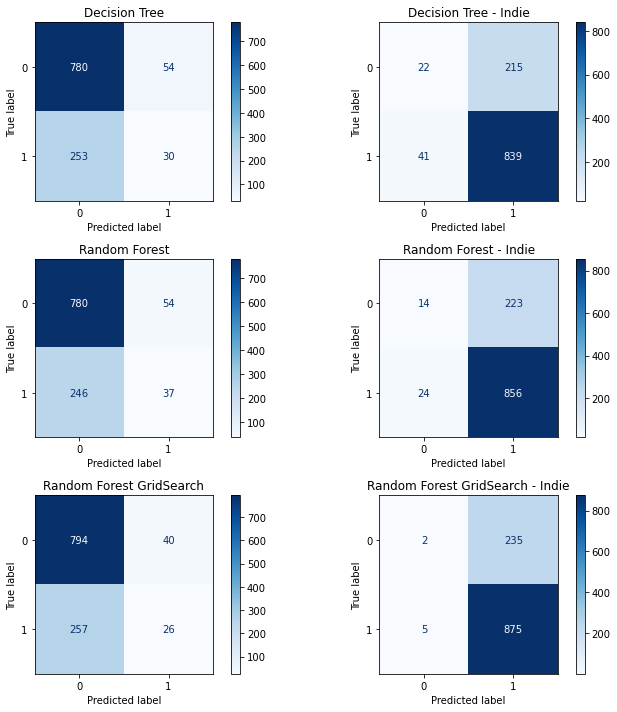

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

classifiers = [baseline, baseline_2, random, random_2, forest_clf_base,forest_clf_base_2]
graph_titles = ['Decision Tree', 'Decision Tree - Indie', 'Random Forest', 'Random Forest - Indie', 'Random Forest GridSearch',  'Random Forest GridSearch - Indie', 
                'Random Forest Only Indie - Over', 'Random Forest Only Indie']
test_values = [(X_test, y_test), (X_test, y_test_2), (X_test, y_test), (X_test, y_test_2), (X_test, y_test), (X_test, y_test_2)]
index = 0
for cls, ax in zip(classifiers, axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(cls, 
                          test_values[index][0], 
                          test_values[index][1], 
                          ax=ax, 
                          cmap='Blues',
                          )
    ax.title.set_text(graph_titles[index])
    index += 1
plt.tight_layout()  
plt.show()

## Results Summary 1
When looking over video games that made over 1 million in sales, the best genres to have adventure, rpg, simulartor and stratgery games. Since there is a satruatration of Adventure and RPG, stratgety and simulator games would be best to make games that people would buy. This may be due to that most games pair these genres togther so it woud best to avoid these genres unless known for the genre themselves. Keep in mind that less games may also mean that most audience may not be looking for that specific genre at all which may limit others to play. The desireable result would being able to make game that encompass multiple genres like adding stragery in their adventure games or shooter platformer. 

WHen looking at the idea of indie developers in mind, there is a slight change in mindset. Indie games have two choice in making a game, make a unique game and define the genre they planned with their game, or go to a niche area that have little to no competition to the genre instead. There seems to be a great deal of interest in indie gmaes as a whole, being consistiently the most important genre in making over 100,000 in sales. If the goal is to start making games, it would be safe to stick with the games in the top feature importance to increase the chances of a good game. Once a genre of games proves to be the best, the best advice would be to conitune to make the games to define themsleves to that genre. Most opeople won't expect anything so stikcing with the common titles would be safest. 

When looking at feature importance when looking at the games labeled with Indie, there was a drascic shift in what the model determine as important. It appeared that RPG and Arcade performed the best for both the threshhols meaning that the most successful indie games were with these genres. Other good genres were variety with platformer, simulator, visual novel, adventure, and fighting. Given how Indie games usually varies, sticking the RPG's and Arcade style games would be best for new developers


## Recommendations

| Rank | Over 1,000,000 | Over 100,000 |
|:---:|:---:|:---:|
| 1 | Adventure | RPG |
| 2 | RPG | Platform |
| 3 | **Simulator** | Adventure |
| 4 | **Puzzle** | **Strategy** |
| 5 | Platform | **Arcade** |

**Triple-A Developer**: <br>
**Safe genres** to make are **Adventure and RPG** due to the reliablity in the gaming market. <br>
Add **puzzle and simulators** for added varity in games to increase performance.

**Indie Developers**: <br>
Avoid uncommon genres and stick to the common genres. **Adventure and RPG** are safe as well along with **platformer and shooters**. <br>
Adding **Strategy or Acade** in their game would increase the likelihood of performing well. 

Next Step
1. Add developer and publisher to the model. 
There is potential markers that may prove to be a igger factor in making a profitable game. 
2. More games
There was a lot of gmaes that weren't added to the final dataframe due to the title not matching perfectly and it would take too much time to individually look and see why that would be the case. More data would ideally lead to better modeling. 
3. Determine trends in genres
Throughout history, there have been trends that I have noticed from game developers make similar sytle of games. Some example on the top of my head was the MOBA, Open World and Battle Royal trend in most recent years where they were extremely popular and widely made even poorly. 

## Confusion Matrixes
Confusion matrix shows the results for the model and what the true values are and what was predicted. There are no cases for this matrix
If both the model and the values are indicated as not profitable, that is knowned as a true negative.
If both the model and the values are indicated as profitable, that is knowned as a true postive.
If the model predicts a positvie, and the values was actually a negative, that is knowned as a false positve. 
If the model predicts a negative, and the values was actually a positve, that is knowned as a false negative. 

Based off the models results when deciding a successful game, the model have a tendecy to predict that all the games are not profitable, leading to a lot of false negatives. 
The default parameter for random forest perform the best with the most true prediction for both profitable and non profitable games. The class inbalance is making a big differnece in the score and should be looked at. 

When looking at the Indie version of the models, they perform much better than the others. The models were able to predict the profitable well with only the fewer false positives. However, this may be due to the fact that there are more profitable games then not with this metric. It appears that the model declare most as profitable but does increase from models as more is categorizese correctly. 

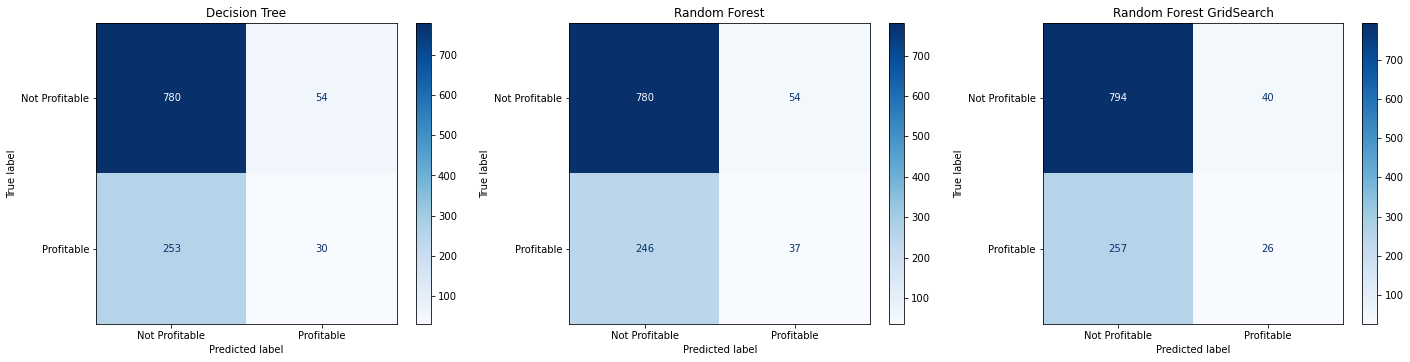

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
classifiers = [baseline, random, forest_clf_base]
graph_titles = ['Decision Tree', 'Random Forest', 'Random Forest GridSearch']
index = 0
for cls, ax in zip(classifiers, axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels= ['Not Profitable', 'Profitable'])
    ax.title.set_text(graph_titles[index])
    index += 1
plt.tight_layout()  
plt.show()

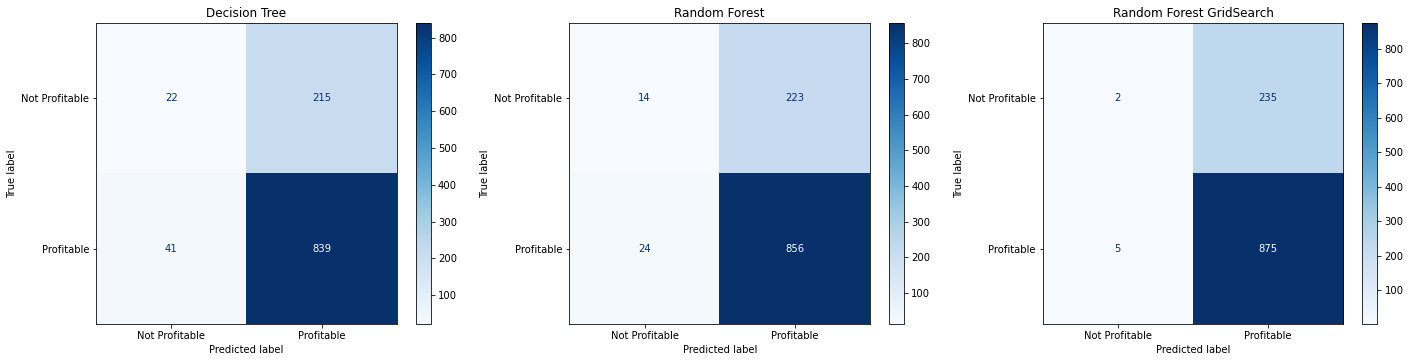

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
classifiers = [baseline_2, random_2, forest_clf_base_2]
graph_titles = ['Decision Tree', 'Random Forest', 'Random Forest GridSearch']
index = 0
for cls, ax in zip(classifiers, axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(cls, 
                          X_test, 
                          y_test_2, 
                          ax=ax, 
                          cmap='Blues',
                          display_labels= ['Not Profitable', 'Profitable'])
    ax.title.set_text(graph_titles[index])
    index += 1
plt.tight_layout()  
plt.show()

In [27]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state= 10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

X_train_bal = X_train_resampled.sample(frac= .5, replace = True, random_state= 10)
y_train_bal = y_train_resampled.sample(frac= .5, replace = True, random_state= 10)

In [28]:
baseline_bal = DecisionTreeClassifier(random_state=10)  
baseline_bal.fit(X_train_bal, y_train_bal) 

random_bal = RandomForestClassifier(random_state=10) 
random_bal.fit(X_train_bal, y_train_bal) 


RandomForestClassifier(random_state=10)

In [29]:
forest_clf_bal = RandomForestClassifier()
forest_clf_grid_search_bal = GridSearchCV(forest_clf_bal, param_grid_2, return_train_score= True, cv= 3, scoring= 'f1')
forest_clf_grid_search_bal.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 10, 15, 20, 25, 30],
                         'max_features': [None, 'sqrt', 10, 15, 20],
                         'min_samples_leaf': [0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 4,
                                              6, 10],
                         'min_samples_split': [0.1, 0.3, 0.5, 0.7, 0.9, 2, 4, 6,
                                               10],
                         'n_estimators': [10, 20, 50, 75, 100],
                         'random_state': [10]},
             return_train_score=True, scoring='f1')

In [30]:
# {'criterion': 'entropy',
#  'max_depth': None,
#  'max_features': None,
#  'min_samples_leaf': 0.1,
#  'min_samples_split': 0.7,
#  'n_estimators': 10,
#  'random_state': 10}

forest_clf_grid_search_bal.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.7,
 'n_estimators': 10,
 'random_state': 10}

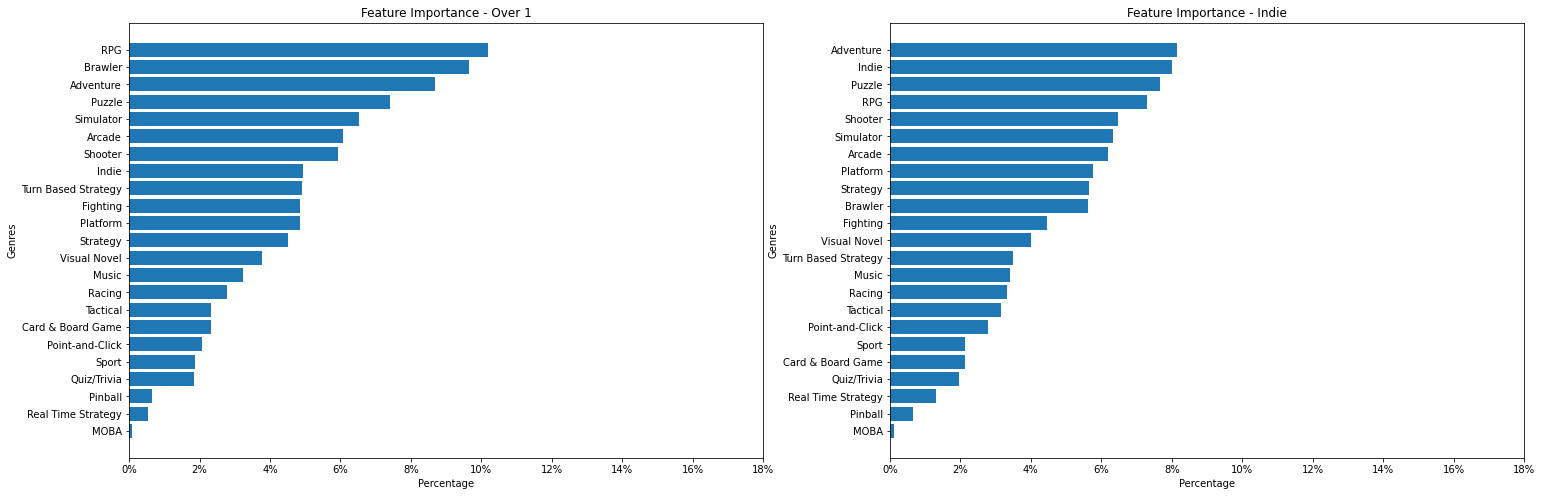

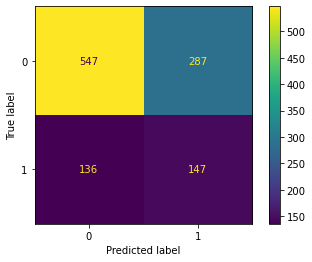

In [31]:
random_list = dc.convert_feature(baseline_bal)
random_list_2 = dc.convert_feature(random_bal)

dv.visual_baseline(random_list, random_list_2)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test,random_bal.predict(X_test)))
disp.plot()

In [32]:
print('Decision Tree - Baseline')
print('___________________')
print('Over 1 Million')
print('F1-Score: {}%'.format(round(f1_score(y_test, baseline_bal.predict(X_test)), 4)* 100))          ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test, baseline_bal.predict(X_test)), 4)* 100))    ### Over 1 Default Random Over 100,000

print('___________________')
print('Random Forest')
print('___________________')

print('Over 1 Million')
print('F1-Score: {}%'.format(round(f1_score(y_test, random_bal.predict(X_test))* 100, 2)))          ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test, random_bal.predict(X_test))* 100, 2)))
print('-------------------')

print('___________________')
print('Random Forest GridSearch')
print('___________________')

print('Over 1 Million')
print('F1-Score: {}%'.format(round(f1_score(y_test, forest_clf_grid_search_bal.predict(X_test))* 100), 2))          ### Over 1 Default Random Over 1
print('Accuracy: {}%'.format(round(accuracy_score(y_test, forest_clf_grid_search_bal.predict(X_test)) * 100, 2)))
print('-------------------')


Decision Tree - Baseline
___________________
Over 1 Million
F1-Score: 43.14%
Accuracy: 59.18%
___________________
Random Forest
___________________
Over 1 Million
F1-Score: 41.0%
Accuracy: 62.13%
-------------------
___________________
Random Forest GridSearch
___________________
Over 1 Million
F1-Score: 40%
Accuracy: 25.34%
-------------------
